# Week 4 - Probability Distributions 3 and Mixture Models

Learning contents:

1. Histogram-based density estimation
    - Display histogram densities
2. Kernel density estimation
    - Hypercube Kernel function
    - Gaussian Kernel function
3. K-Nearest Neigbours classification
    - Generate data
    - Classification function
    - Display results
4. K-Means clustering
    - Display results

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import sqrt
from collections import Counter
from scipy.stats import norm
from sklearn import datasets
from IPython.display import HTML

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate data

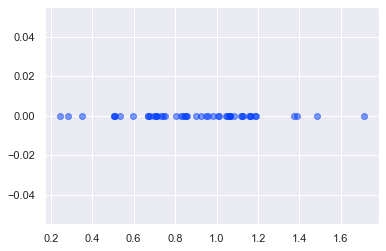

In [2]:
def generate_data_1D(size, means, variances, pis):
    result = 0
    
    for i, (mean, variance, pi) in enumerate(zip(means, variances, pis)):
        result += pi * np.array(norm(mean, sqrt(variance)).rvs(size=size, random_state=26 + i))
    
    return result
    
means = [0.4, 2.0]
variances = [0.2, 0.1]
pis = [0.7, 0.3]
data_1D = generate_data_1D(50, means, variances, pis)

plt.scatter(data_1D, [0] * len(data_1D), alpha=0.5)

## 1) Histogram-based density estimation

`histogram` takes `data`, bin size `delta` and returns `bins` (list of bins where `bin = list of points`) and their `probabilities`

In [3]:
def histogram(data, delta):
    """
    Horrible implementation.
    """
    bin_point = min(data) + delta
    bin_points = []
    while bin_point < max(data):
        bin_points.append(bin_point)
        bin_point += delta
    bin_points.append(bin_point)
    data_sorted = sorted(data)
    bins = []
    for bin_i in bin_points:
        current_bin = []
        while data_sorted[0] < bin_i:
            current_bin.append(data_sorted.pop(0))
            if not data_sorted:
                break
        bins.append(current_bin)
    N = len(data)
    probabilities = [len(bin_i)/(N*delta) for bin_i in bins]
    return bins, probabilities

### 1.1) Display histogram densities

In [4]:
def display_histogram_density(data, delta):
    bins, probabilities = histogram(data, delta)

    plt.bar(range(len(bins)), list(map(lambda b: len(b), bins)))
    plt.plot(range(len(probabilities)), probabilities, '-r')

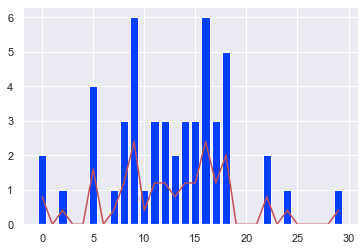

In [5]:
display_histogram_density(data_1D, 0.05)

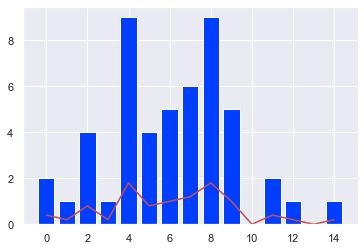

In [6]:
display_histogram_density(data_1D, 0.1)

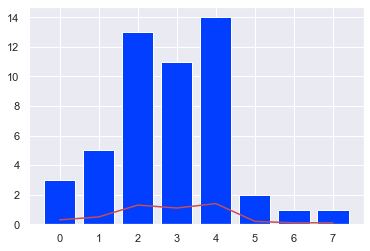

In [7]:
display_histogram_density(data_1D, 0.2)

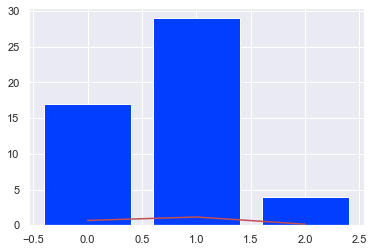

In [8]:
display_histogram_density(data_1D, 0.5)

## 2) Kernel density estimation

### 2.1) Hypercube Kernel function

`hypercube_kernel_function` takes `u` and returns 0 or 1 if `u` is inside 1/2 hypercube

In [9]:
def hypercube_kernel_function(u):
    return 1 if np.linalg.norm(u) <= 1/2 else 0

`hypercube_kernel_density` takes any point `x`, data points `data`, size of a cube `h`, amount of dimensions `D` and returns probability density function based on Hypercube kernel function<br>
Slide 14 lecture 19

In [10]:
def hypercube_kernel_density(x, data, h, D):
    N = len(data)
    return 1/N*sum([1/(h**D) * hypercube_kernel_function((x-x_n)/h) for x_n in data])

In [11]:
def display_hypercube_kernel_density_1D(data, h, color='b'):
    xs = np.linspace(min(data), max(data), 200)
    plt.plot(xs, list(map(lambda x: hypercube_kernel_density(x, data, h, 1), xs)), '-' + color, label='h=' + str(h))
    plt.legend()

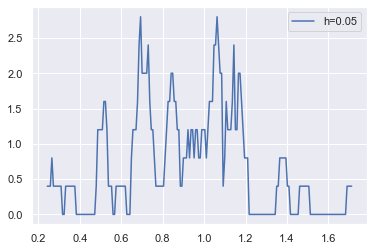

In [12]:
display_hypercube_kernel_density_1D(data_1D, 0.05, 'b')

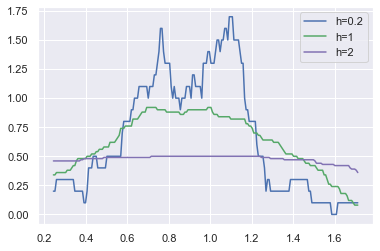

In [13]:
display_hypercube_kernel_density_1D(data_1D, 0.2, 'b')
display_hypercube_kernel_density_1D(data_1D, 1, 'g')
display_hypercube_kernel_density_1D(data_1D, 2, 'm')

### 2.2) Gaussian Kernel function

`gaussian_kernel_function` takes pair of points `x` and `x_n`, size `h` and returns Gaussian kernel function for this pair of points

In [14]:
def gaussian_kernel_function(x, x_n, h):
    return norm.pdf(x, loc=x_n, scale=h)

`gaussian_kernel_density` takes any point `x`, data points `data`, size `h` and returns Gaussian kernel density for point `x`

In [15]:
def gaussian_kernel_density(x, data, h):
    N = len(data)
    return 1/N * sum([gaussian_kernel_function(x, x_n, h) for x_n in data])

In [16]:
def display_gaussian_kernel_density_1D(data, h, color='b'):
    xs = np.linspace(min(data), max(data), 200)
    plt.plot(xs, list(map(lambda x: gaussian_kernel_density(x, data, h), xs)), '-' + color, label='h=' + str(h))
    plt.legend()

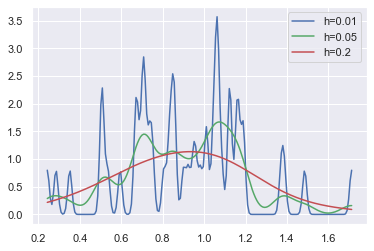

In [17]:
display_gaussian_kernel_density_1D(data_1D, 0.01, 'b')
display_gaussian_kernel_density_1D(data_1D, 0.05, 'g')
display_gaussian_kernel_density_1D(data_1D, 0.2, 'r')

## 3) K-Nearest Neigbours classification

### 3.1) Generate Data

(<matplotlib.collections.PathCollection at 0x1684c7cac88>,
 <matplotlib.legend.Legend at 0x1684c7d3288>)

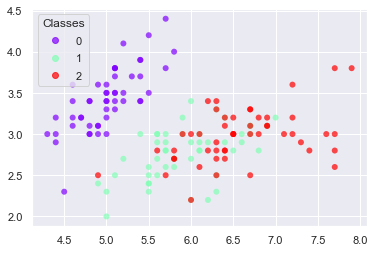

In [18]:
iris = datasets.load_iris()
iris_x = np.array(iris.data[:, :2])  # we only take the first two features.
iris_t = np.array(iris.target)

def plot_iris(legend=True, classes=iris_t, target=plt):
    scatter = target.scatter(iris_x[:, 0], iris_x[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

plot_iris()

### 3.2) Classification function

`k_nearest_classification` takes any point `x`, data point positions `data_x`, their classes `data_t`, amount of neighbours `k` and returns class for the point `x`

In [42]:
def k_nearest_classification(x, data_x, data_t, k):
    data_pairs = zip(data_x, data_t)
    k_nearest = sorted(data_pairs, key=lambda y: np.linalg.norm(y[0] - x))[:k]
    dict_of_freq = Counter([label for point, label in k_nearest])
    max_class = max(dict_of_freq, key=dict_of_freq.get)
    return max_class

### 3.3) Display results

In [43]:
def plot_mesh(pred_fn, n_class=3, x_min=4, x_max=8, y_min=2, y_max=4.5, target=plt):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.array(list(map(lambda x: pred_fn(np.array(x)), np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)
    cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    target.axis('tight')
    if hasattr(target, 'xlim'):
        target.xlim(x_min, x_max)
        target.ylim(y_min, y_max)

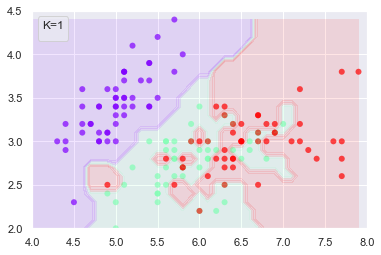

In [44]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 1))
plt.legend([], loc="upper left", title="K=1")

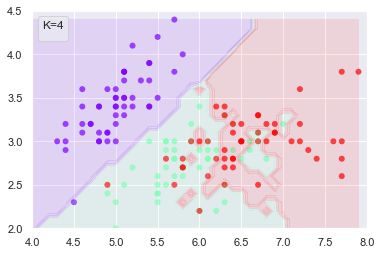

In [45]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 4))
plt.legend([], loc="upper left", title="K=4")

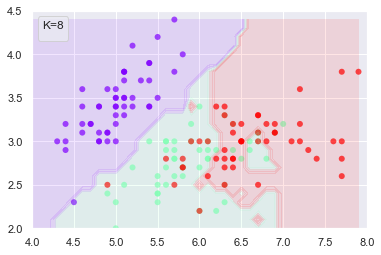

In [46]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 8))
plt.legend([], loc="upper left", title="K=8")

## 4) K-Means clustering

`k_means_step` takes initial means `mus_0`, data points `data_x` and returns new means `mus` and `classes`

In [125]:
def k_means_step(mus_0, data_x):
    classes = []
    for x in data_x:
#         for mu_k in mus_0:
#             print(np.linalg.norm(x, np.array(mu_k)))
#             print(list(x))
        distances = {class_k: np.linalg.norm((x, mu_k)) for class_k, mu_k in enumerate(mus_0)}
        classes.append(min(distances, key=distances.get))
    data_old_class = zip(data_x, classes)
    class_dict = {}
    for k, mu_k in enumerate(mus_0):
        if tuple(mu_k) not in class_dict:
            class_dict[tuple(mu_k)] = []
        for x, x_class in data_old_class:
            if x_class == k:
                class_dict[tuple(mu_k)].append(x)
    print(class_dict)
    for mu_k in class_dict:
        if class_dict[mu_k]:
            class_dict[mu_k] = np.mean(np.vstack(class_dict[mu_k]), axis=0)
    mus = [class_dict[mu_k] for mu_k in class_dict]
    return mus, classes

In [115]:
testers = np.array([2, 3])
testers2 = np.array([4, 5])
testlst = [testers, testers2]
np.mean(np.vstack(testlst), axis=0)
len(iris_x)

150

In [126]:
k = 3
mus_0 = iris_x[:k]

all_steps = []

#optimize_k_means(mus_0, iris_x, lambda mus, classes: all_steps.append((mus, classes)))
k_means_step(mus_0, iris_x)

{(5.1, 3.5): [], (4.9, 3.0): [], (4.7, 3.2): []}


([[], [], []],
 [2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2])

In [80]:
iris_x[:3]
# for x in iris_x[:3]:
#     print(x)

array([[5.1, 3.5],
       [4.9, 3. ],
       [4.7, 3.2]])

`distortion_measure` takes means `mus`, `classes`, data points `data_x` and returns distortion of this classification

In [60]:
def distortion_measure(mus, classes, data_x):
    
    result = 0
    
    for i, c in enumerate(classes):
        
        x = data_x[i]
        mu = mus[c]
        distance = np.dot(np.array(mu) - np.array(x), np.array(mu) - np.array(x))
        result += distance
    
    return result

`optimize_k_means` takes initial means `mus_0`, data points `data_x` and callback `on_step`

`on_step` is a function that takes current `mus` and `classes` and should be called each step 

In [61]:
def optimize_k_means(mus_0, data_x, on_step):
    return on_step(k_means_step(mus_0, data_x))

### 4.1) Display results

In [62]:
def plot_k_means(mus, classes, target=plt):
    plot = plot_iris(classes=classes, target=target)
    scatter = target.scatter(mus[:, 0], mus[:, 1], c=[0, 1, 2], cmap='rainbow', marker='X', s=300, edgecolors='black')
    return (*plot, scatter)

In [101]:
k = 3
mus_0 = iris_x[:k]

all_steps = []

#optimize_k_means(mus_0, iris_x, lambda mus, classes: all_steps.append((mus, classes)))
k_means_step(mus_0, iris_x)

ValueError: need at least one array to concatenate

In [ ]:
def create_animation(all_steps, data_x):
    
    distortions = list(map(
        lambda a: distortion_measure(a[0], a[1], data_x),
        all_steps
    ))
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        plot1 = plot_k_means(all_steps[i][0], all_steps[i][1], target=ax)
        ax2.plot(list(range(i)), distortions[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Distortion')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps, iris_x)